## Practico primero programar en Jupyter

Debo  colocar las librerias que si o si se utilizaran 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes

Creo la función en assembler

In [2]:
%%file calculo_varianza.asm
 global calculoVarianzaAsm 
  ; extern double calcularVarianzaASM(arr,cantidad); 
  ;       xmm0                        rdi rsi   
section .bss 
    auxiliar resq 1 
    media resq 1

section .text
   calculoVarianzaAsm:
    ;xorpd  xmm0,xmm0;limpio las variables 
    xorpd  xmm1,xmm1
    xorpd  xmm2,xmm2
    xorpd  xmm3,xmm3
    xorpd  xmm4,xmm4
    xorpd  xmm5,xmm5
    xor rax,rax
    xor rcx,rcx
    xor r10,r10
    ;primero sacamos la media 
    mov rcx,rsi; muevo para realizar el loop 
    cvtsi2sd xmm3,rcx 
    calcular_media:
        movsd xmm1,[rdi +r10]
        ;cvtsi2sd xmm1,[rdi +r10]
        add r10,8
        divsd xmm1,xmm3
        addsd xmm2,xmm1
        loop calcular_media
    mov rcx,rsi
    xor r10,r10
    xorpd xmm1,xmm1
    xor rax,rax
    sumatoria:
        movsd xmm1,[rdi +r10]
        ;cvtsi2sd xmm1,[rdi +r10]
        add r10,8
        subsd xmm1,xmm2
        mulsd xmm1,xmm1
        addsd xmm4,xmm1
        loop sumatoria
    divsd xmm4,xmm3

exit:
        movsd xmm0, xmm4
ret 

Overwriting calculo_varianza.asm


Aqui empiezo la programación del main 

In [5]:
%%file funcionmain.c
#include <stdio.h>
#include<math.h>
#include<stdlib.h>

// aqui declaro las funciones
double media(double*,int);
double calculovarianzaC(double*,int);
extern double calculoVarianzaAsm(double *,int ); 

int main(int argc, char **argv){
    double calculoC,calculoASM,d=0.5,valor;
    int i, N, cantpar, r2,a=4;
    double *arr;
    N = argc - 1; 
    arr = (double*) malloc(N*sizeof(double));
    //printf("%d\n", sizeof(arr));
    
    if (argc < 2){
        N = 3;
        for (i = 0; i < N; i++) arr[i] = i;
    } else{
        for (i = 1; i < argc; i++) arr[i-1] = (double)atoi(argv[i]);
    }
    calculoC=calculovarianzaC(arr,N);
    printf("la varianza en C  es %lf \n",calculoC); 
    calculoASM=calculoVarianzaAsm(arr,N);
    printf("la varianza en ASM es %lf \n",calculoASM);
    return 0;
}
double media(double *v, int tam){
    double m,suma=0;
    for(int i=0;i<tam;i++)
        suma+=v[i];
    
    m=(double)suma/tam;
return m;
}
double calculovarianzaC(double *v,int cant){
    double varianza,med=media(v,cant);
    for(int i=0;i<cant;i++)
        varianza+= pow(v[i]-med,2);
    return ((double)varianza/cant);
}

Overwriting funcionmain.c


Aquí lo compilo y genero el archivo objeto de mi función en assembler y linkeo los archivos

In [6]:
! nasm -g -f elf64 calculo_varianza.asm -o calculoASM.o
! gcc -g calculoASM.o  funcionmain.c -o varianza -lm
! ./varianza 1 2 3 4 5

la varianza en C  es 2.000000 
la varianza en ASM es 2.000000 


Escribo el gdb 

In [20]:
%%file depurador.gdb 
set logging file reporte.txt
set print pretty on
set logging on
set pagination off
file varianza
define hook-echo
echo <------
end
define hookpost-echo
echo ------>\n
end
set args 1 2 3 4 5 
b main
b calculoVarianzaAsm
b calcular_media
b sumatoria 
b exit 
r
c
ni
c
set $cont=$ecx
echo calculo de la  media
while ($cont>0)
    p $xmm1.v2_double[0] 
    p $xmm2.v2_double[0]
    p $cont
    c
    #set $aux= $aux -1
    set $cont= $ecx 
end
set $cont = $ecx 
#set $aux = 6
echo calculo de la sumatoria
while ($cont>0)
    p $xmm1.v2_double[0] 
    p $xmm4.v2_double[0]
    p $cont
    c
    #set $aux= $aux -1
    set $cont= $ecx 
end
    p $xmm4.v2_double[0]
quit


Overwriting depurador.gdb


In [21]:
! gdb -x depurador.gdb

GNU gdb (Ubuntu 9.1-0ubuntu1) 9.1
Copyright (C) 2020 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "x86_64-linux-gnu".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
    <http://www.gnu.org/software/gdb/documentation/>.

For help, type "help".
Type "apropos word" to search for commands related to "word".
Breakpoint 1 at 0x11d7: file funcionmain.c, line 10.
Breakpoint 2 at 0x1170
Breakpoint 3 at 0x1195
Breakpoint 4 at 0x11b6
Breakpoint 5 at 0x11d2

Breakpoint 1, main (argc=21845, argv=0x7fffffffdd36) at funcionmain.c:10
10	int main(int argc, char **argv){
la varianza en C  e

---------------------------------------------------------------------

## Empiezo  a practicar para calcular graficas

 Creo el file en C de la función assembler

In [7]:
%%file caculoAsm_varianza.c
extern double calcularVarianzaASM(double *,int );

Overwriting caculoAsm_varianza.c


 Generamos la libería

In [8]:
! nasm -g -f elf64 calculo_varianza.asm -o calculoASM.o
! gcc -g -shared calculoASM.o  caculoAsm_varianza.c -o calculoVarianzaAsm.so

In [9]:
%%file calculoC_varianza.c
#include <stdio.h>
#include<math.h>
#include<stdlib.h>
double media(double *v, int tam){
    double m,suma=0;
    for(int i=0;i<tam;i++)
        suma+=v[i];
    
    m=(double)suma/tam;
return m;
}
double calculovarianzaC(double *v,int cant){
    double varianza,med=media(v,cant);
    for(int i=0;i<cant;i++)
        varianza+= pow(v[i]-med,2);
    return ((double)varianza/cant);
}

Overwriting calculoC_varianza.c


In [10]:
! gcc -c -Wall -Werror -fpic calculoC_varianza.c
! gcc -shared calculoC_varianza.o -o calculovarianzaC.so

In [11]:
def ctypes_calculoVarianzaAsm():
    #indicar la ruta del a shared library 
    libfile='./calculoVarianzaAsm.so'
    #cargar la shared library
    lib=ctypes.CDLL(libfile)
    #si quisiera poner double es np.float64
    lib.calculoVarianzaAsm.argtypes=[
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    #tipo de dato que devuelve
    lib.calculoVarianzaAsm.restype=ctypes.c_double
    return lib.calculoVarianzaAsm

In [12]:
def ctypes_calculovarianzaC():
    #indicar la ruta del a shared library 
    libfile='./calculovarianzaC.so'
    #cargar la shared library
    lib= ctypes.CDLL(libfile)
    #si quisiera poner double es np.float64
    lib.calculovarianzaC.argtypes=[
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    #tipo de dato que devuelve
    lib.calculovarianzaC.restype=ctypes.c_double
    return lib.calculovarianzaC

In [13]:
# tam
size = 5

# entradas
x = np.random.rand(size,1).astype(np.float64)
#y = np.random.rand(size,1).astype(np.float32)

calculoVarianzaAsm=ctypes_calculoVarianzaAsm()
calculovarianzaC=ctypes_calculovarianzaC()


pruebo las dos funciones

In [14]:
calculoVarianzaAsm(x,size)==calculovarianzaC(x,size)

True

In [15]:
calculoVarianzaAsm(x,size)

0.07478330576100099

In [16]:
calculovarianzaC(x,size)

0.07478330576100099

Función auxiliar llamada filtro mediana

In [23]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

Variables donde estarán las mediciones

In [33]:
# modulo para medir el tiempo
import time

# tamaños de los arreglos
sizes = 2**np.arange(1,10)

# tiempos de la suma de arreglos de floats64 en C
tc = np.zeros((len(sizes),1),dtype=np.float64)#retorna un arreglo vacío
#            filas=4,colum=1, tipo
# tiempos de la suma de arreglos de floats64 en ASM
tasm = np.zeros((len(sizes),1),dtype=np.float64)

# tiempo con ruido en C
tcr = np.zeros((len(sizes),1),dtype=np.float64)

# tiempo con ruido en ASM
tasmr = np.zeros((len(sizes),1),dtype=np.float64)

# Mediciones para el caso más pequeño

In [34]:
# primero el caso más pequeño
veces = 40
tam = sizes[0]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = np.random.rand(tam,1).astype(np.float64)
    #yp = np.random.rand(tam,1).astype(np.float64)
    
    # tiempo C
    t = time.time()
    rc = calculovarianzaC(xp,tam)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    rasm = calculoVarianzaAsm(xp,tam)
    tasmp.append(time.time() - t)

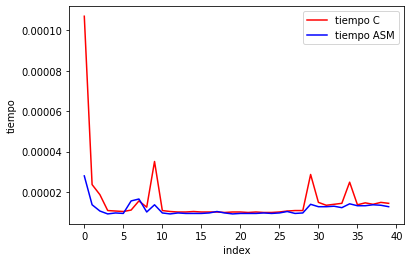

In [35]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
plt.show()

Gráficos de los mediciones sin ruido para distintos tamaño de ventana

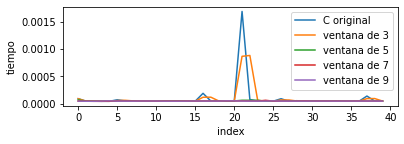

In [40]:
# primero los tiempos de C
plt.subplot(2,1,1)
plt.plot(index, tcp, label='C original')
plt.plot(index, filtro_mediana(tcp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tcp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tcp,7), label='ventana de 7')
plt.plot(index, filtro_mediana(tcp,9), label='ventana de 9')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()


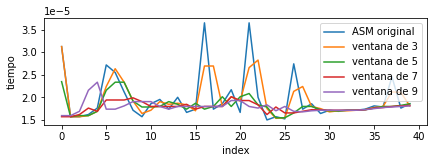

In [41]:

# luego los tiempos de ASM
plt.subplot(2,1,2)
plt.plot(index, tasmp, label='ASM original')
plt.plot(index, filtro_mediana(tasmp,3), label='ventana de 3')
plt.plot(index, filtro_mediana(tasmp,5), label='ventana de 5')
plt.plot(index, filtro_mediana(tasmp,7), label='ventana de 7')
plt.plot(index, filtro_mediana(tasmp,9), label='ventana de 9')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
# para evitar que los gráficos estén muy pegados
plt.tight_layout()

Comparación del promedio con ruido y sin ruido en el caso pequegno de la función en C y ASM

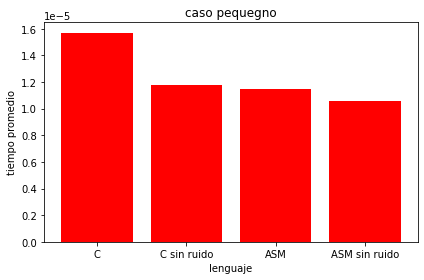

In [37]:
noms = ['C','C sin ruido','ASM','ASM sin ruido']
proms = [ 
    statistics.mean(tcp), 
    statistics.mean(filtro_mediana(tcp,9)),
    statistics.mean(tasmp), 
    statistics.mean(filtro_mediana(tasmp,9))
]
plt.bar(noms,proms,color='r')
plt.xlabel('lenguaje')
plt.ylabel('tiempo promedio')
plt.title('caso pequegno')
plt.tight_layout()

# Mediciones para el caso mas grande

In [38]:
# primero el caso más pequeño
veces = 40
tam = sizes[-1]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = np.random.rand(tam,1).astype(np.float64)
    #yp = np.random.rand(tam,1).astype(np.float64)
    
    # tiempo C
    t = time.time()
    rc = calculovarianzaC(xp,tam)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    rasm = calculoVarianzaAsm(xp,tam)
    tasmp.append(time.time() - t)

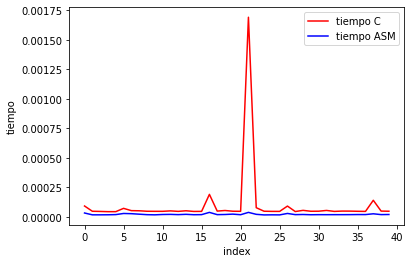

In [39]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
plt.show()

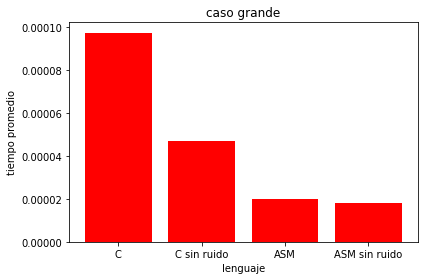

In [42]:
noms = ['C','C sin ruido','ASM','ASM sin ruido']
proms = [ 
    statistics.mean(tcp), 
    statistics.mean(filtro_mediana(tcp,9)),
    statistics.mean(tasmp), 
    statistics.mean(filtro_mediana(tasmp,9))
]
plt.bar(noms,proms,color='r')
plt.xlabel('lenguaje')
plt.ylabel('tiempo promedio')
plt.title('caso grande')
plt.tight_layout()